In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 1
commitnumber = d5931a1
conc = None
dv = 0.02
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 50
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 257
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

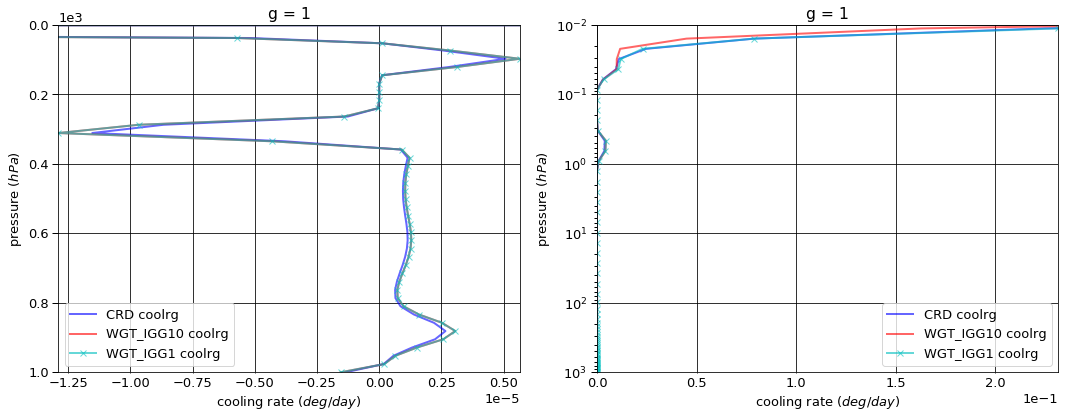

# Figure: cooling rate g-group 2

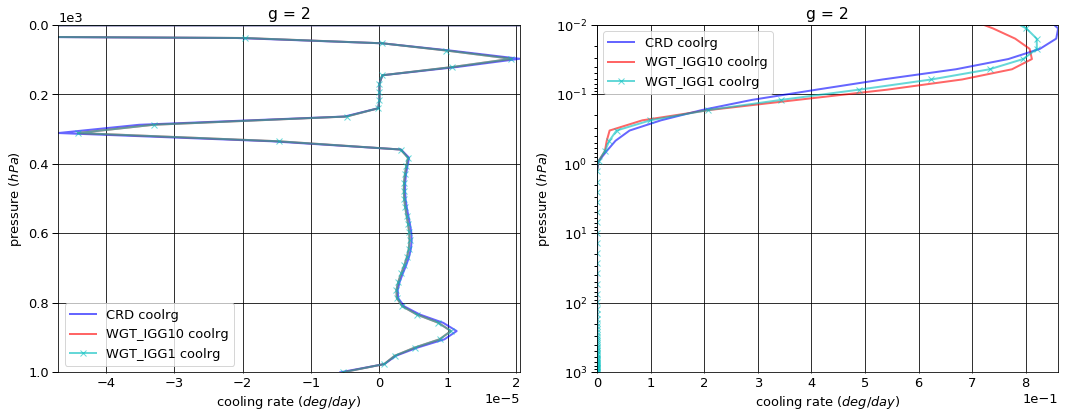

# Figure: cooling rate g-group 3

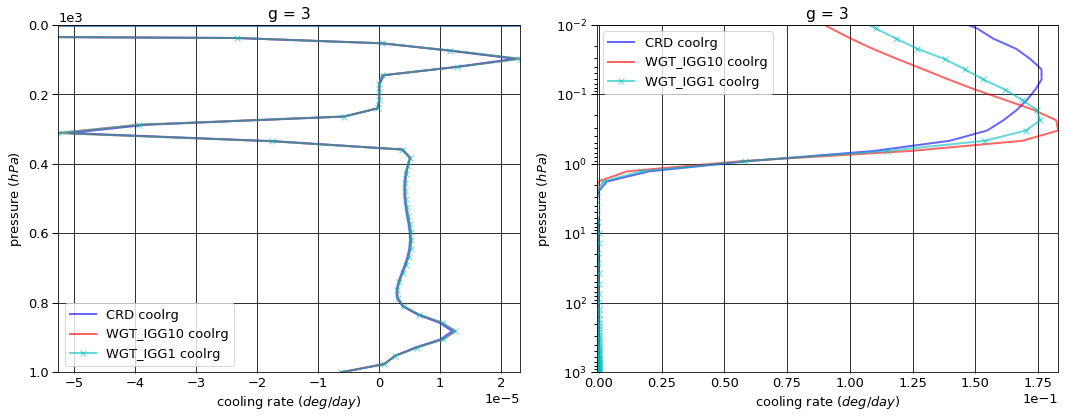

# Figure: cooling rate g-group 4

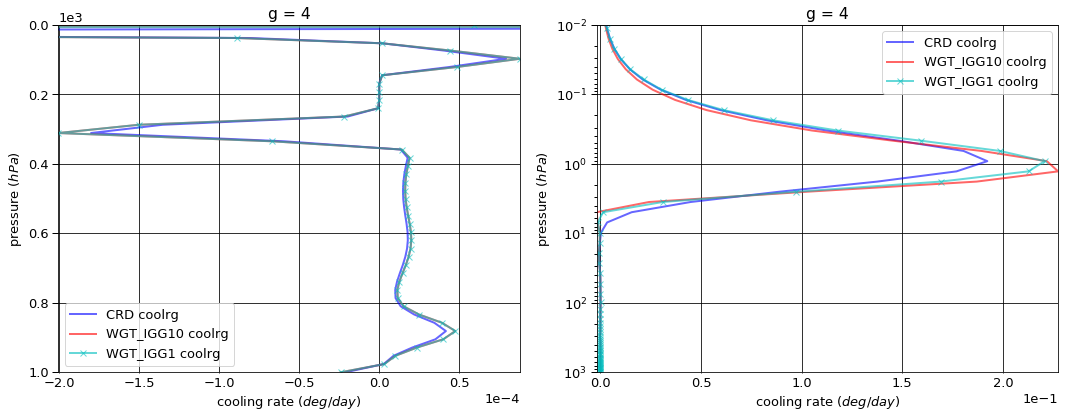

# Figure: cooling rate g-group 5

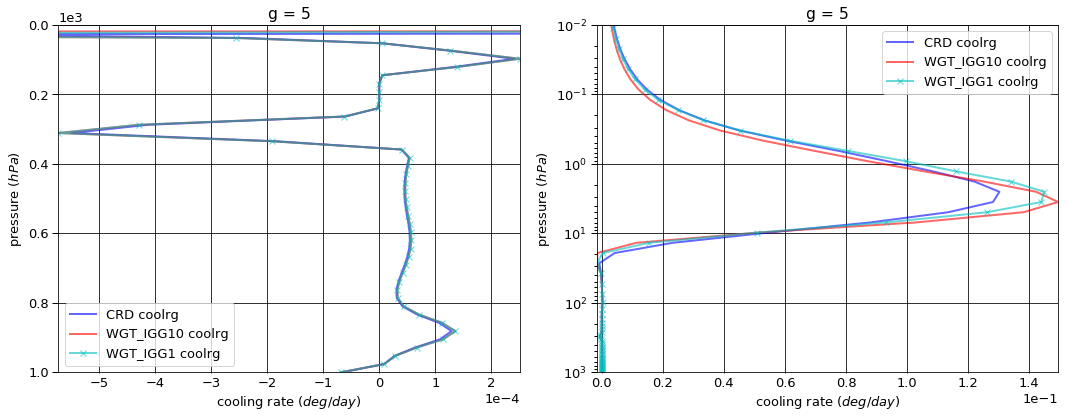

# Figure: cooling rate g-group 6

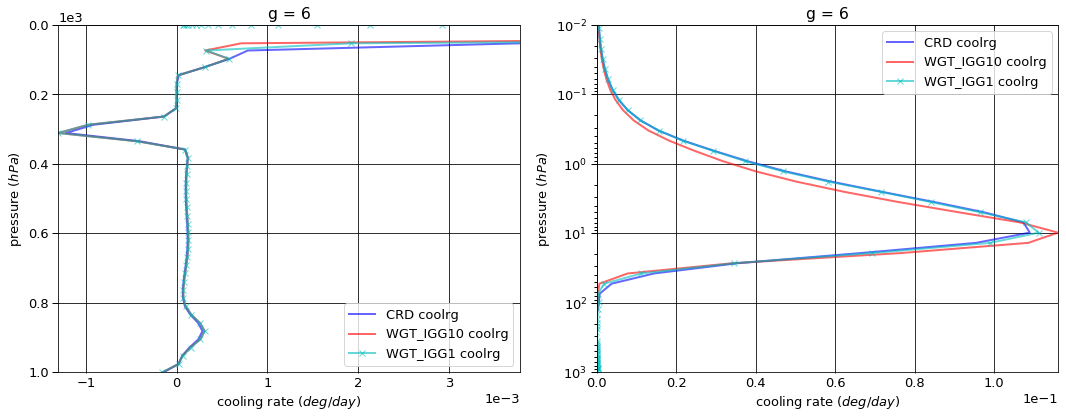

# Figure: cooling rate g-group 7

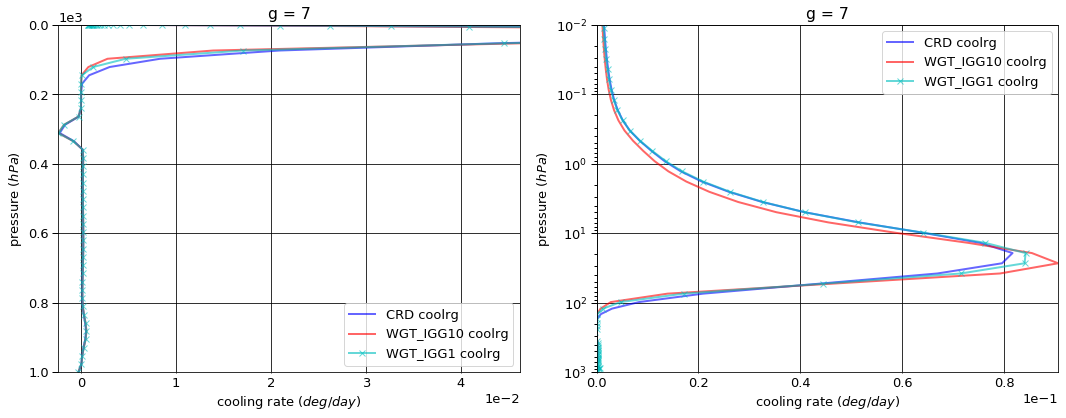

# Figure: cooling rate g-group 8

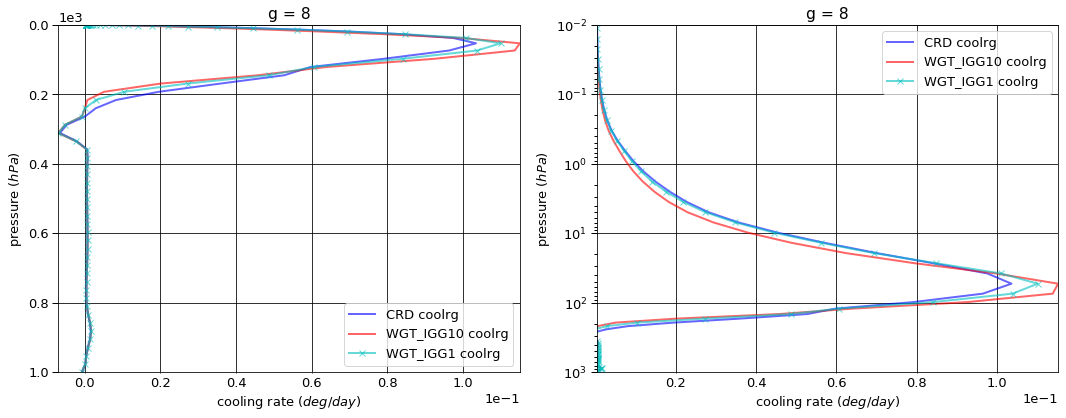

# Figure: cooling rate g-group 9

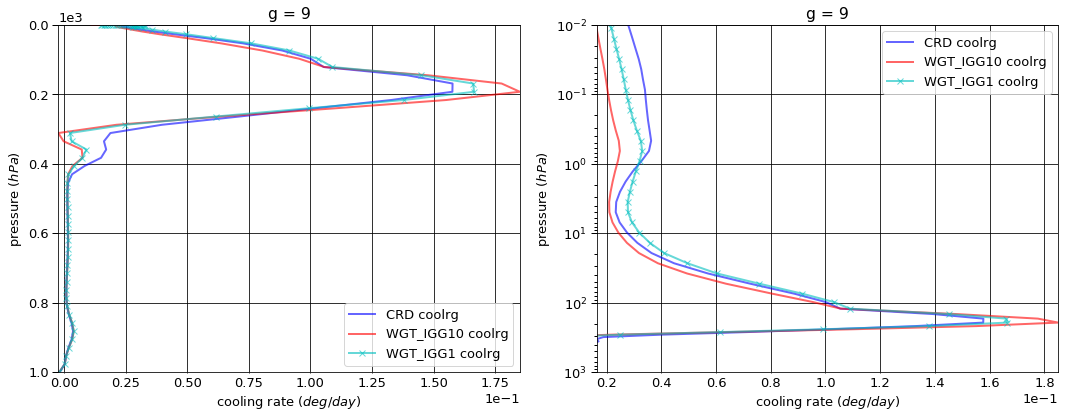

# Figure: cooling rate g-group 10

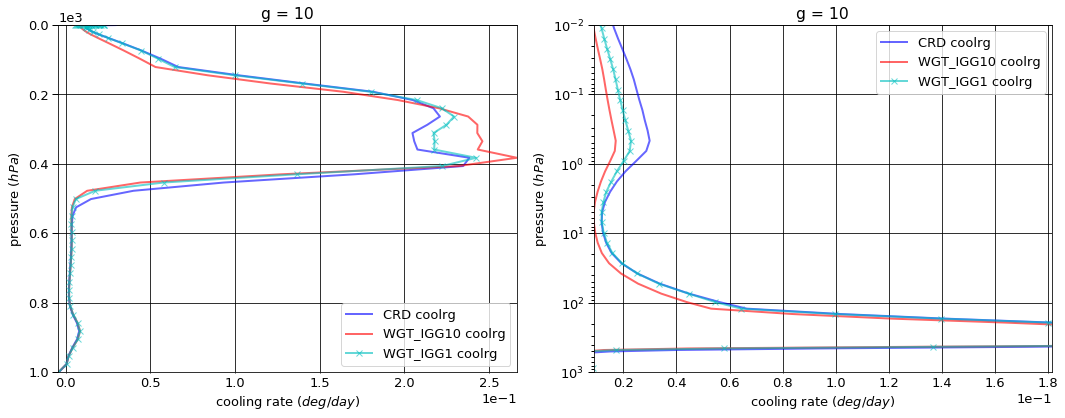

# Figure: cooling rate g-group 11

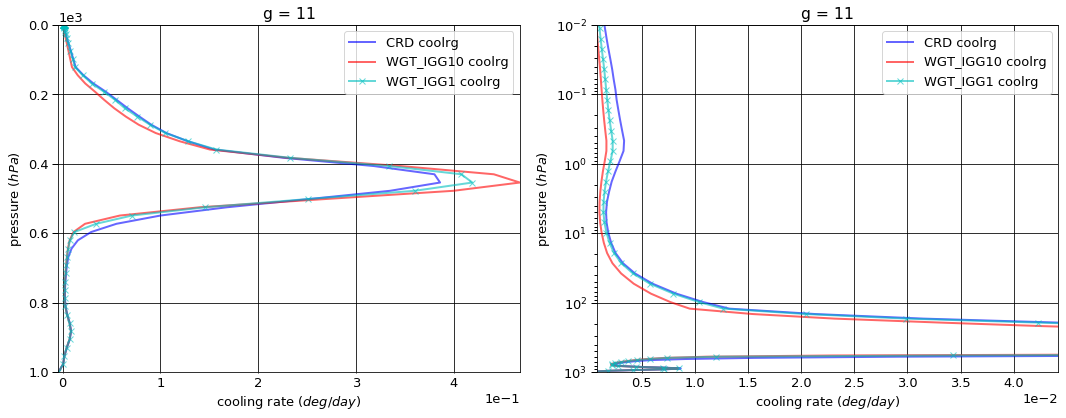

# Figure: cooling rate g-group 12

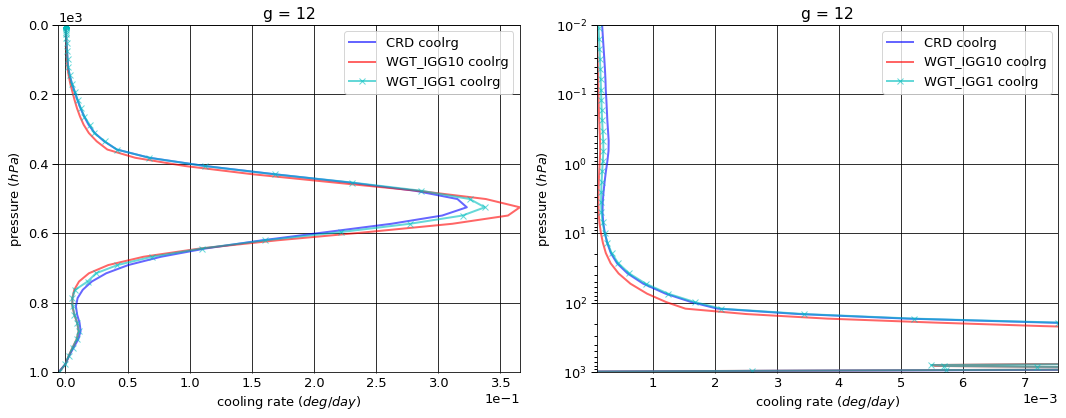

# Figure: cooling rate g-group total

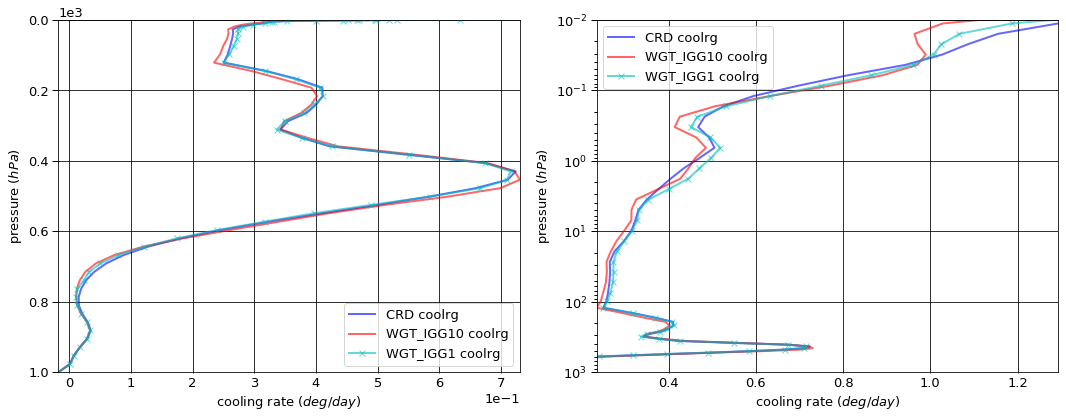

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.003020   0.000000 -0.003020
   1013.0   76     -0.003937   0.003946  0.000009
2  0.0      1      -0.012397   0.000000 -0.012397
   1013.0   76     -0.013590   0.013627  0.000037
3  0.0      1      -0.015635   0.000000 -0.015635
   1013.0   76     -0.016143   0.016183  0.000039
4  0.0      1      -0.054775   0.000000 -0.054775
   1013.0   76     -0.061210   0.061347  0.000138
5  0.0      1      -0.137052   0.000000 -0.137052
   1013.0   76     -0.175319   0.175744  0.000425
6  0.0      1      -0.295033   0.000000 -0.295033
   1013.0   76     -0.398470   0.399408  0.000939
7  0.0      1      -0.532668   0.000000 -0.532668
   1013.0   76     -0.732833   0.734567  0.001734
8  0.0      1      -1.582675   0.000000 -1.582675
   1013.0   76     -2.159866   2.164998  0.005132
9  0.0      1      -3.752031   0.000000 -3.752031
   1013.0   76     -5.061509   5.073515  0.012006
10 0.0      1      -8.390007   0.000000 -8.390007
   1013.0   76    -10.997068  11.023483  0.026415
11 0.0      1      -8.834088   0.000000 -8.834088
   1013.0   76    -10.922288  10.950821  0.028533
12 0.0      1      -8.344835   0.000000 -8.344835
   1013.0   76     -9.719234   9.757777  0.038543


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002922   0.000000 -0.002922
   1013.0   76     -0.003961   0.003972  0.000010
2  0.0      1      -0.012483   0.000000 -0.012483
   1013.0   76     -0.013537   0.013572  0.000034
3  0.0      1      -0.015804   0.000000 -0.015804
   1013.0   76     -0.016176   0.016217  0.000041
4  0.0      1      -0.055243   0.000000 -0.055243
   1013.0   76     -0.061578   0.061734  0.000157
5  0.0      1      -0.136581   0.000000 -0.136581
   1013.0   76     -0.175744   0.176191  0.000447
6  0.0      1      -0.288146   0.000000 -0.288146
   1013.0   76     -0.399987   0.401005  0.001018
7  0.0      1      -0.519204   0.000000 -0.519204
   1013.0   76     -0.735480   0.737351  0.001872
8  0.0      1      -1.548811   0.000000 -1.548811
   1013.0   76     -2.167232   2.172747  0.005515
9  0.0      1      -3.671415   0.000000 -3.671415
   1013.0   76     -5.079153   5.092078  0.012925
10 0.0      1      -8.229080   0.000000 -8.229080
   1013.0   76    -11.028777  11.056842  0.028066
11 0.0      1      -8.846563   0.000000 -8.846563
   1013.0   76    -10.917638  10.945473  0.027835
12 0.0      1      -8.463593   0.000000 -8.463593
   1013.0   76     -9.662207   9.695754  0.033547


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002930   0.000000 -0.002930
   1013.0   76     -0.003961   0.003972  0.000010
2  0.0      1      -0.012476   0.000000 -0.012476
   1013.0   76     -0.013537   0.013572  0.000034
3  0.0      1      -0.015734   0.000000 -0.015734
   1013.0   76     -0.016176   0.016217  0.000041
4  0.0      1      -0.055154   0.000000 -0.055154
   1013.0   76     -0.061578   0.061734  0.000157
5  0.0      1      -0.136767   0.000000 -0.136767
   1013.0   76     -0.175744   0.176191  0.000447
6  0.0      1      -0.288767   0.000000 -0.288767
   1013.0   76     -0.399987   0.401005  0.001018
7  0.0      1      -0.520186   0.000000 -0.520186
   1013.0   76     -0.735480   0.737351  0.001872
8  0.0      1      -1.549070   0.000000 -1.549070
   1013.0   76     -2.167232   2.172747  0.005515
9  0.0      1      -3.670269   0.000000 -3.670269
   1013.0   76     -5.079153   5.092078  0.012925
10 0.0      1      -8.224667   0.000000 -8.224667
   1013.0   76    -11.028777  11.056842  0.028066
11 0.0      1      -8.807217   0.000000 -8.807217
   1013.0   76    -10.917638  10.945557  0.027919
12 0.0      1      -8.425083   0.000000 -8.425083
   1013.0   76     -9.662207   9.696256  0.034049


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000098  0.000000  0.000098
   1013.0   76    -0.000025  0.000026  0.000001
2  0.0      1     -0.000086  0.000000 -0.000086
   1013.0   76     0.000053 -0.000056 -0.000003
3  0.0      1     -0.000169  0.000000 -0.000169
   1013.0   76    -0.000033  0.000034  0.000002
4  0.0      1     -0.000468  0.000000 -0.000468
   1013.0   76    -0.000368  0.000387  0.000019
5  0.0      1      0.000470  0.000000  0.000470
   1013.0   76    -0.000425  0.000447  0.000022
6  0.0      1      0.006887  0.000000  0.006887
   1013.0   76    -0.001517  0.001596  0.000079
7  0.0      1      0.013464  0.000000  0.013464
   1013.0   76    -0.002646  0.002784  0.000138
8  0.0      1      0.033864  0.000000  0.033864
   1013.0   76    -0.007366  0.007749  0.000384
9  0.0      1      0.080616  0.000000  0.080616
   1013.0   76    -0.017643  0.018563  0.000919
10 0.0      1      0.160927  0.000000  0.160927
   1013.0   76    -0.031709  0.033359  0.001651
11 0.0      1     -0.012475  0.000000 -0.012475
   1013.0   76     0.004650 -0.005348 -0.000697
12 0.0      1     -0.118758  0.000000 -0.118758
   1013.0   76     0.057027 -0.062023 -0.004996


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000089  0.000000  0.000089
   1013.0   76    -0.000025  0.000026  0.000001
2  0.0      1     -0.000079  0.000000 -0.000079
   1013.0   76     0.000053 -0.000056 -0.000003
3  0.0      1     -0.000100  0.000000 -0.000100
   1013.0   76    -0.000033  0.000034  0.000002
4  0.0      1     -0.000379  0.000000 -0.000379
   1013.0   76    -0.000368  0.000387  0.000019
5  0.0      1      0.000284  0.000000  0.000284
   1013.0   76    -0.000425  0.000447  0.000022
6  0.0      1      0.006266  0.000000  0.006266
   1013.0   76    -0.001517  0.001596  0.000079
7  0.0      1      0.012482  0.000000  0.012482
   1013.0   76    -0.002646  0.002784  0.000138
8  0.0      1      0.033605  0.000000  0.033605
   1013.0   76    -0.007366  0.007749  0.000384
9  0.0      1      0.081762  0.000000  0.081762
   1013.0   76    -0.017643  0.018563  0.000919
10 0.0      1      0.165340  0.000000  0.165340
   1013.0   76    -0.031709  0.033359  0.001651
11 0.0      1      0.026871  0.000000  0.026871
   1013.0   76     0.004650 -0.005264 -0.000614
12 0.0      1     -0.080248  0.000000 -0.080248
   1013.0   76     0.057027 -0.061521 -0.004494

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer           
1  0.000312    1      10.395524
   1001.112500 75     -0.000001
2  0.000312    1       0.421788
   1001.112500 75     -0.000006
3  0.000312    1       0.073126
   1001.112500 75     -0.000006
4  0.000312    1       0.000065
   1001.112500 75     -0.000021
5  0.000312    1       0.001140
   1001.112500 75     -0.000065
6  0.000312    1       0.000065
   1001.112500 75     -0.000144
7  0.000312    1       0.000787
   1001.112500 75     -0.000266
8  0.000312    1       0.000206
   1001.112500 75     -0.000788
9  0.000312    1       0.019060
   1001.112500 75     -0.001844
10 0.000312    1       0.007677
   1001.112500 75     -0.004058
11 0.000312    1       0.000624
   1001.112500 75     -0.004414
12 0.000312    1       0.000104
   1001.112500 75     -0.005770


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      7.883573
   1001.112500 75    -0.000002
2  0.000312    1      0.314775
   1001.112500 75    -0.000005
3  0.000312    1      0.043223
   1001.112500 75    -0.000006
4  0.000312    1      0.000052
   1001.112500 75    -0.000024
5  0.000312    1      0.000976
   1001.112500 75    -0.000069
6  0.000312    1      0.000059
   1001.112500 75    -0.000156
7  0.000312    1      0.000613
   1001.112500 75    -0.000288
8  0.000312    1      0.000153
   1001.112500 75    -0.000848
9  0.000312    1      0.011186
   1001.112500 75    -0.001986
10 0.000312    1      0.004215
   1001.112500 75    -0.004313
11 0.000312    1      0.000318
   1001.112500 75    -0.004281
12 0.000312    1      0.000052
   1001.112500 75    -0.005326


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      8.453585
   1001.112500 75    -0.000002
2  0.000312    1      0.391070
   1001.112500 75    -0.000005
3  0.000312    1      0.053526
   1001.112500 75    -0.000006
4  0.000312    1      0.000059
   1001.112500 75    -0.000024
5  0.000312    1      0.001117
   1001.112500 75    -0.000069
6  0.000312    1      0.000069
   1001.112500 75    -0.000156
7  0.000312    1      0.000729
   1001.112500 75    -0.000288
8  0.000312    1      0.000183
   1001.112500 75    -0.000848
9  0.000312    1      0.014893
   1001.112500 75    -0.001986
10 0.000312    1      0.005665
   1001.112500 75    -0.004313
11 0.000312    1      0.000438
   1001.112500 75    -0.004300
12 0.000312    1      0.000073
   1001.112500 75    -0.005266


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.511951e+00
   1001.112500 75    -1.991186e-07
2  0.000312    1     -1.070133e-01
   1001.112500 75     4.283691e-07
3  0.000312    1     -2.990271e-02
   1001.112500 75    -2.601500e-07
4  0.000312    1     -1.280689e-05
   1001.112500 75    -2.961801e-06
5  0.000312    1     -1.643680e-04
   1001.112500 75    -3.422229e-06
6  0.000312    1     -5.895090e-06
   1001.112500 75    -1.220859e-05
7  0.000312    1     -1.738594e-04
   1001.112500 75    -2.132436e-05
8  0.000312    1     -5.318933e-05
   1001.112500 75    -5.924669e-05
9  0.000312    1     -7.874542e-03
   1001.112500 75    -1.420034e-04
10 0.000312    1     -3.462409e-03
   1001.112500 75    -2.549773e-04
11 0.000312    1     -3.058942e-04
   1001.112500 75     1.329928e-04
12 0.000312    1     -5.184820e-05
   1001.112500 75     4.435968e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.941939e+00
   1001.112500 75    -1.991186e-07
2  0.000312    1     -3.071843e-02
   1001.112500 75     4.283691e-07
3  0.000312    1     -1.960024e-02
   1001.112500 75    -2.601500e-07
4  0.000312    1     -5.075930e-06
   1001.112500 75    -2.961801e-06
5  0.000312    1     -2.337430e-05
   1001.112500 75    -3.422229e-06
6  0.000312    1      3.902791e-06
   1001.112500 75    -1.220859e-05
7  0.000312    1     -5.855914e-05
   1001.112500 75    -2.132436e-05
8  0.000312    1     -2.250361e-05
   1001.112500 75    -5.924669e-05
9  0.000312    1     -4.167481e-03
   1001.112500 75    -1.420034e-04
10 0.000312    1     -2.011754e-03
   1001.112500 75    -2.549773e-04
11 0.000312    1     -1.858290e-04
   1001.112500 75     1.144303e-04
12 0.000312    1     -3.119115e-05
   1001.112500 75     5.037243e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.954216,0.000000,-31.954216
1013.0,76,-40.261468,40.375417,0.113949



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.789846,0.000000,-31.789846
1013.0,76,-40.261468,40.372935,0.111468



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.708320,0.000000,-31.708320
1013.0,76,-40.261468,40.373521,0.112053



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.643695e-01,0.000000,0.164369
1013.0,76,-5.461000e-07,-0.002482,-0.002481



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.458950e-01,0.000000,0.245895
1013.0,76,-5.461000e-07,-0.001896,-0.001896


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,10.920166
1001.112500,75,-0.017385



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,8.259195
1001.112500,75,-0.017305



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,8.921406
1001.112500,75,-0.017263



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.660971
1001.112500,75,0.000080



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.998760
1001.112500,75,0.000122


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000250,0.000336
3,0.000500,0.000402
4,0.001875,0.001529
5,0.004750,0.004365
6,0.012188,0.009935
7,0.020625,0.018268
8,0.064562,0.053829
9,0.150812,0.126154


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.428976e-16
2,5.434972e-17
3,8.614503e-18
4,1.160099e-17
5,2.152872e-18
6,3.995224e-19
7,6.708836e-19
8,1.270181e-19
9,2.404829e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.428976e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,5.434972e-17,0.158501,0.000250,0.000336,0.000375,0.000435,1.0
3,8.614503e-18,0.158501,0.000500,0.000402,0.000875,0.000836,1.0
4,1.160099e-17,1.346682,0.001875,0.001529,0.002750,0.002366,30.0
5,2.152872e-18,0.185577,0.004750,0.004365,0.007500,0.006731,30.0
6,3.995224e-19,0.185577,0.012188,0.009935,0.019688,0.016666,30.0
7,6.708836e-19,1.679214,0.020625,0.018268,0.040313,0.034933,300.0
8,1.270181e-19,0.189330,0.064562,0.053829,0.104875,0.088762,300.0
9,2.404829e-20,0.189330,0.150812,0.126154,0.255687,0.214916,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
